In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [2]:
directory = os.getenv('HOME') + '/aiffel/aiffelthon/meta/'

In [3]:
os.listdir(directory)

['reg_1.json',
 'meta_data_included_raw_v2.csv',
 '.ipynb_checkpoints',
 'meta_eng_raw_0306_v1.csv',
 'kor_text.xlsx',
 'reg_3.json',
 'meta_data_included_raw.csv',
 'meta_raw_eng_corrected_sts_v1.csv',
 'meta_data_raw_eng_match_6m.csv',
 'kor_text.txt',
 'meta_raw_eng_sts_v1.csv',
 'reg_4.json',
 'meta_raw_eng_corrected_sts_v1_needs_correction_translated.xlsx',
 '사투리화_데이터셋_0309.csv',
 'meta_raw_eng_corrected_sts_v1_needs_correction.xlsx',
 'kw_t.json',
 'reg_5.json',
 'meta_raw_eng_corrected_sts_v_final.csv',
 'meta_data_raw_0306.csv',
 'reg_2.json',
 'meta_raw_eng_corrected_sts_saturization_v_final.csv']

In [257]:
df = pd.read_csv(directory + 'meta_raw_eng_corrected_sts_saturization_v_final.csv',usecols=['reg','topic','stdn','dial_edit_f2','eng'] )

In [258]:
df =df.rename(columns = {'dial_edit_f2':'dial'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949888 entries, 0 to 949887
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   reg     949888 non-null  object
 1   topic   949888 non-null  object
 2   stdn    949888 non-null  object
 3   eng     949888 non-null  object
 4   dial    949888 non-null  object
dtypes: object(5)
memory usage: 36.2+ MB


In [259]:
import re

In [264]:
en_t = []
dial_t = []
for i in range(len(df)) :
    en_match = re.search('\.|\.|\?|\!$',df.eng.values[i])
    dial_match = re.search('\.|\.|\?|\!$',df.dial.values[i])
    if not en_match and dial_match :
        en_t.append(df.eng.values[i] + re.search('\.|\.|\?|\!$',df.dial.values[i]).group())
        dial_t.append(df.dial.values[i])
    else :
        en_t.append(df.eng.values[i])
        dial_t.append(df.dial.values[i])
        
df['eng_punctuation'] = en_t
del df['eng']
df =df.rename(columns = {'eng_punctuation':'eng'})

In [265]:
df.head()

,reg,topic,stdn,dial,eng
0,jd,역사,생각이 쪼금씩 바뀌더라고,생각이 쪼금씩 바뀌드라고,I've changed my mind a little bit.
1,jd,가족,어 알겠는가 외국인들이 그래도 잘 적응하고,웜마 알겄는가 애국인들이 그또 달 적응하고,You know what? Foreigners still get used to it.
2,jd,건강,아으 갑자기 예전에 맹장 뜯은 게 생각난다.,아으 갑자기 에전에 맹장 뜯은 게잉 생각난디야.,"All of a sudden, I think I've ripped off my ap..."
3,jd,스타일,보면은 조금 품위 있게 나이 들어가야 되겠단 생각을 참 많이 해요.,보먼은 좀 품위 있게 나이 들어가야 되겠단 싱각을 참 마이 해요잉.,I have a lot of ideas about getting older in a...
4,jd,먹거리,약간 조금 약간 맛이 쪼끔 거시기 하긴 한데 그래도,약깐 좀 약깐 맛이가 쪼까 머시기 카긴 한디 그또,"It's a little bit of a tastey, but still..."


In [8]:
import sentencepiece as spm

en_tokenizer = spm.SentencePieceProcessor()
en_tokenizer.Load(os.getenv('HOME') + '/aiffel/saturi/MODEL/spmen_r1.model')
ko_tokenizer = spm.SentencePieceProcessor()
ko_tokenizer.Load(os.getenv('HOME') + '/aiffel/saturi/MODEL/spmko_r1.model')

True

In [266]:
test = df.iloc[:100].dial.values.tolist()
tok_eng_len = 0
char_len =0

for i in test :
    char_len += len(i)
    tok_eng_len += len(ko_tokenizer.encode_as_pieces(i))
print(char_len/tok_eng_len)

1.74


In [294]:
def create_long_seq(df, reg, topic, num_seq,seq_len,char_len) :
    max_len = int(num_seq*seq_len*char_len)

    ds = df.loc[(df['reg'] == reg)&(df['topic'] == topic)].copy()
    ds = ds.sample(frac=1, random_state=1)

    test_text_dial = ds['dial'].values
    test_text_eng = ds['eng'].values
    test_iter_dial = iter(test_text_dial)
    test_iter_eng = iter(test_text_eng)
    
    more_examples =True
    
    while more_examples :
        
        buffer_len = 0
        buffer_eng = []
        buffer_dial = []

        while True :
            try :
                text_new_dial = next(test_iter_dial)
                text_new_eng = next(test_iter_eng)
#                 buffer_len += len(text_new_dial)
                buffer_len += len(text_new_eng)

                if max_len <= buffer_len :
                    break
                else :
                    buffer_eng.append(text_new_eng)
                    buffer_dial.append(text_new_dial)
            except :
                test_iter_dial = iter(test_text_dial)
                test_iter_eng = iter(test_text_eng)

        long_sentences = dict()
        long_sentences['data'] = []

        for seq_no in range(num_seq,len(buffer_eng),num_seq):
            try:
                lst_eng = ' '.join(buffer_eng[seq_no: seq_no+num_seq])
                lst_dial= ' '.join(buffer_dial[seq_no: seq_no+num_seq])
            except:
                continue

            long_sentences['data'].append({'reg':reg, 'topic':topic,'eng':lst_eng,'dial':lst_dial})

        for i in long_sentences['data'] :
            yield i

In [295]:
import tqdm

def generate_long_sequences(df, regs, topics, num_seq,seq_len, char_len) :
    long_sentences_final = dict()
    long_sentences_final['data'] = []
    print('start')

    for reg in regs :
        for topic in topics :
            num_long_sentences = len(df.loc[(df['reg'] == reg)&(df['topic'] == topic)]) // num_seq
            print(num_long_sentences,end=' ')
            if num_long_sentences > 2:
                gen = iter(create_long_seq(df, reg, topic, num_seq, seq_len,char_len))
            else :
                continue
            for i in range(num_long_sentences) :
                long_sentences_final['data'].append(next(gen))
    print('슝<')
    return long_sentences_final

In [296]:
regs = df.reg.unique()
topics = df.topic.unique()

In [297]:
final_dict = {}
final_dict['data'] = []
for num in [64,128,256,512] :
    seq_len = num * 2
    char_len = 2
    num_seq = seq_len // 20 # 시퀀스 average 길이
    long_sentences_final = generate_long_sequences(df, regs, topics,num_seq,seq_len,char_len)
    final_dict['data'].extend(long_sentences_final['data'])

start
202 1413 1645 621 1938 788 1078 711 817 883 1239 1356 497 997 914 511 1432 763 397 219 822 1000 625 1685 331 441 939 318 182 606 712 213 542 161 512 587 422 364 117 121 1356 6459 2124 305 4204 1635 427 889 945 188 769 3398 408 555 467 387 1605 87 77 234 546 327 303 2507 67 148 582 214 49 276 248 400 312 58 142 248 660 71 162 37 76 929 834 757 1558 414 460 478 527 332 614 608 362 1058 636 283 786 655 254 107 486 607 335 915 153 498 350 135 79 414 654 173 425 64 226 354 275 511 181 34 152 741 993 541 1016 544 500 408 423 523 578 704 484 584 424 559 744 480 424 267 456 509 401 1060 282 358 621 334 198 493 382 331 429 312 409 441 361 414 46 191 23 16465 1360 144 2159 1268 136 1130 1026 4934 367 4746 72 1477 1339 224 9386 990 20 1151 782 658 260 1336 1232 533 804 23 25 519 43 1095 47 1342 122 43 68 17 115 42 슝<
start
101 706 822 310 969 394 539 355 408 441 619 678 248 498 457 255 716 381 198 109 411 500 312 842 165 220 469 159 91 303 356 106 271 80 256 293 211 182 58 60 678 3229 1062 

In [298]:
long_df = pd.DataFrame(final_dict['data'])

In [299]:
long_df

,reg,topic,eng,dial
0,jd,역사,Wouldn't you be able to make another announcem...,다른 나라에게 또잉 알릴 수 있제 않을까? 뭣하러 역살 공부를 혀야 대는 건지 얘...
1,jd,역사,Because I think there are too many things to m...,왜냐면 외워야 대는 거이 하도 많다고잉 싱각을 한께. 칠 년전쟁에서 이순신 장군님...
2,jd,역사,But the Dabotap was also taken out of Japan wi...,근디 또잉 고 다보탑에 성물과 사리암 등걸이가 일본으로 반출되었댜 그거이 달 안 ...
3,jd,역사,I'll let you guys keep an eye on my country ar...,우리나라 요기 광주쯤은 니네가 지켜볼 수 있게 해줄게. 긍게 고 고구려가 쩜쩜 ...
4,jd,역사,It's a little bit of a focus thing. I don't kn...,이케잉 쫌 집중되는 경향이 있긴 한디 달달한 헌 가도 그거이 모양새가 겹치지 않는...
...,...,...,...,...
293719,kw,정치,Five hours and the vote's over. That's why I c...,다섯시간만 지나믄 투패가 끝나. 개가주 몬 가서 하튼 지 중국놈들은 어뜬 기 사실...
293720,kw,법률,It smells like piss. That's what I'm doing. If...,오즘 내금새 난다고. 그레 하구 앉은 자리데이. 요게가 만일에 그이 삼십 오십으...
293721,kw,법률,I'm going to put her in court. Who is it? They...,그이 년아를 법정에 세울 겁니다. 느그? 지네 자석 굶기면서 옳은 소라리 카는 ...
293722,kw,법률,"Oh, my God. Detective Joe, if that's the case,...",이그 촌니나. 조 헹사님 그믄 저한데 기횔 여게가 바빨리 길인데 애미한테 인사...


In [300]:
long_df.drop_duplicates(inplace=True)

In [301]:
len(long_df)

287592

In [302]:
s = []
test = iter(long_df.eng.values)
for i in test :
    s.append(len(en_tokenizer.encode(i)))

In [303]:
long_df

,reg,topic,eng,dial
0,jd,역사,Wouldn't you be able to make another announcem...,다른 나라에게 또잉 알릴 수 있제 않을까? 뭣하러 역살 공부를 혀야 대는 건지 얘...
1,jd,역사,Because I think there are too many things to m...,왜냐면 외워야 대는 거이 하도 많다고잉 싱각을 한께. 칠 년전쟁에서 이순신 장군님...
2,jd,역사,But the Dabotap was also taken out of Japan wi...,근디 또잉 고 다보탑에 성물과 사리암 등걸이가 일본으로 반출되었댜 그거이 달 안 ...
3,jd,역사,I'll let you guys keep an eye on my country ar...,우리나라 요기 광주쯤은 니네가 지켜볼 수 있게 해줄게. 긍게 고 고구려가 쩜쩜 ...
4,jd,역사,It's a little bit of a focus thing. I don't kn...,이케잉 쫌 집중되는 경향이 있긴 한디 달달한 헌 가도 그거이 모양새가 겹치지 않는...
...,...,...,...,...
293719,kw,정치,Five hours and the vote's over. That's why I c...,다섯시간만 지나믄 투패가 끝나. 개가주 몬 가서 하튼 지 중국놈들은 어뜬 기 사실...
293720,kw,법률,It smells like piss. That's what I'm doing. If...,오즘 내금새 난다고. 그레 하구 앉은 자리데이. 요게가 만일에 그이 삼십 오십으...
293721,kw,법률,I'm going to put her in court. Who is it? They...,그이 년아를 법정에 세울 겁니다. 느그? 지네 자석 굶기면서 옳은 소라리 카는 ...
293722,kw,법률,"Oh, my God. Detective Joe, if that's the case,...",이그 촌니나. 조 헹사님 그믄 저한데 기횔 여게가 바빨리 길인데 애미한테 인사...


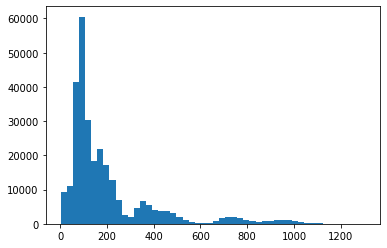

In [304]:
fig = plt.figure()
plt.hist(s,bins=50)
plt.show()

In [306]:
long_df.eng.values[8000]

'Imuse Im just going to get my dream I took it all away from me.'

In [310]:
long_df.columns

Index(['reg', 'topic', 'eng', 'dial'], dtype='object')

In [311]:
merg_df= df[long_df.columns]

In [313]:
merg_df = pd.concat([merg_df,long_df], axis=0)

In [314]:
merg_df.drop_duplicates(inplace=True)

In [315]:
merg_df

,reg,topic,eng,dial
0,jd,역사,I've changed my mind a little bit.,생각이 쪼금씩 바뀌드라고
1,jd,가족,You know what? Foreigners still get used to it.,웜마 알겄는가 애국인들이 그또 달 적응하고
2,jd,건강,"All of a sudden, I think I've ripped off my ap...",아으 갑자기 에전에 맹장 뜯은 게잉 생각난디야.
3,jd,스타일,I have a lot of ideas about getting older in a...,보먼은 좀 품위 있게 나이 들어가야 되겠단 싱각을 참 마이 해요잉.
4,jd,먹거리,"It's a little bit of a tastey, but still...",약깐 좀 약깐 맛이가 쪼까 머시기 카긴 한디 그또
...,...,...,...,...
293719,kw,정치,Five hours and the vote's over. That's why I c...,다섯시간만 지나믄 투패가 끝나. 개가주 몬 가서 하튼 지 중국놈들은 어뜬 기 사실...
293720,kw,법률,It smells like piss. That's what I'm doing. If...,오즘 내금새 난다고. 그레 하구 앉은 자리데이. 요게가 만일에 그이 삼십 오십으...
293721,kw,법률,I'm going to put her in court. Who is it? They...,그이 년아를 법정에 세울 겁니다. 느그? 지네 자석 굶기면서 옳은 소라리 카는 ...
293722,kw,법률,"Oh, my God. Detective Joe, if that's the case,...",이그 촌니나. 조 헹사님 그믄 저한데 기횔 여게가 바빨리 길인데 애미한테 인사...


In [316]:
merg_df.reg.value_counts()

kw    447946
jj    263531
jd    225840
gs    148743
cc    144651
Name: reg, dtype: int64

In [333]:
merg_df['tok_len'] = merg_df['eng'].apply(lambda x : len(en_tokenizer.encode(x)))

In [367]:
merg_df['tok_cat'] = pd.qcut(merg_df['tok_len'], [0,.3,.6,.7,.75,.8,.85,.9,.95,.99,1], [0,1,2,3,4,5,6,7,8,9])

In [368]:
merg_df['tok_cat'].value_counts()

0    406222
1    344500
2    121773
7     61405
5     61252
4     61170
6     60552
3     52315
8     49246
9     12276
Name: tok_cat, dtype: int64

In [376]:
tok_cats = merg_df['tok_cat'].unique()

In [380]:
merg_df.reset_index(drop=True, inplace=True)

In [445]:
save_indx_test =[]
for reg in regs :
    temp = merg_df.loc[merg_df.reg == reg].copy()
    temp = temp.sample(300, weights='tok_cat')
    save_indx_test.extend(temp.index)

In [451]:
test_df = merg_df.iloc[save_indx_test].copy()

In [452]:
train_df = merg_df.loc[~merg_df.index.isin(save_indx_test)].copy()

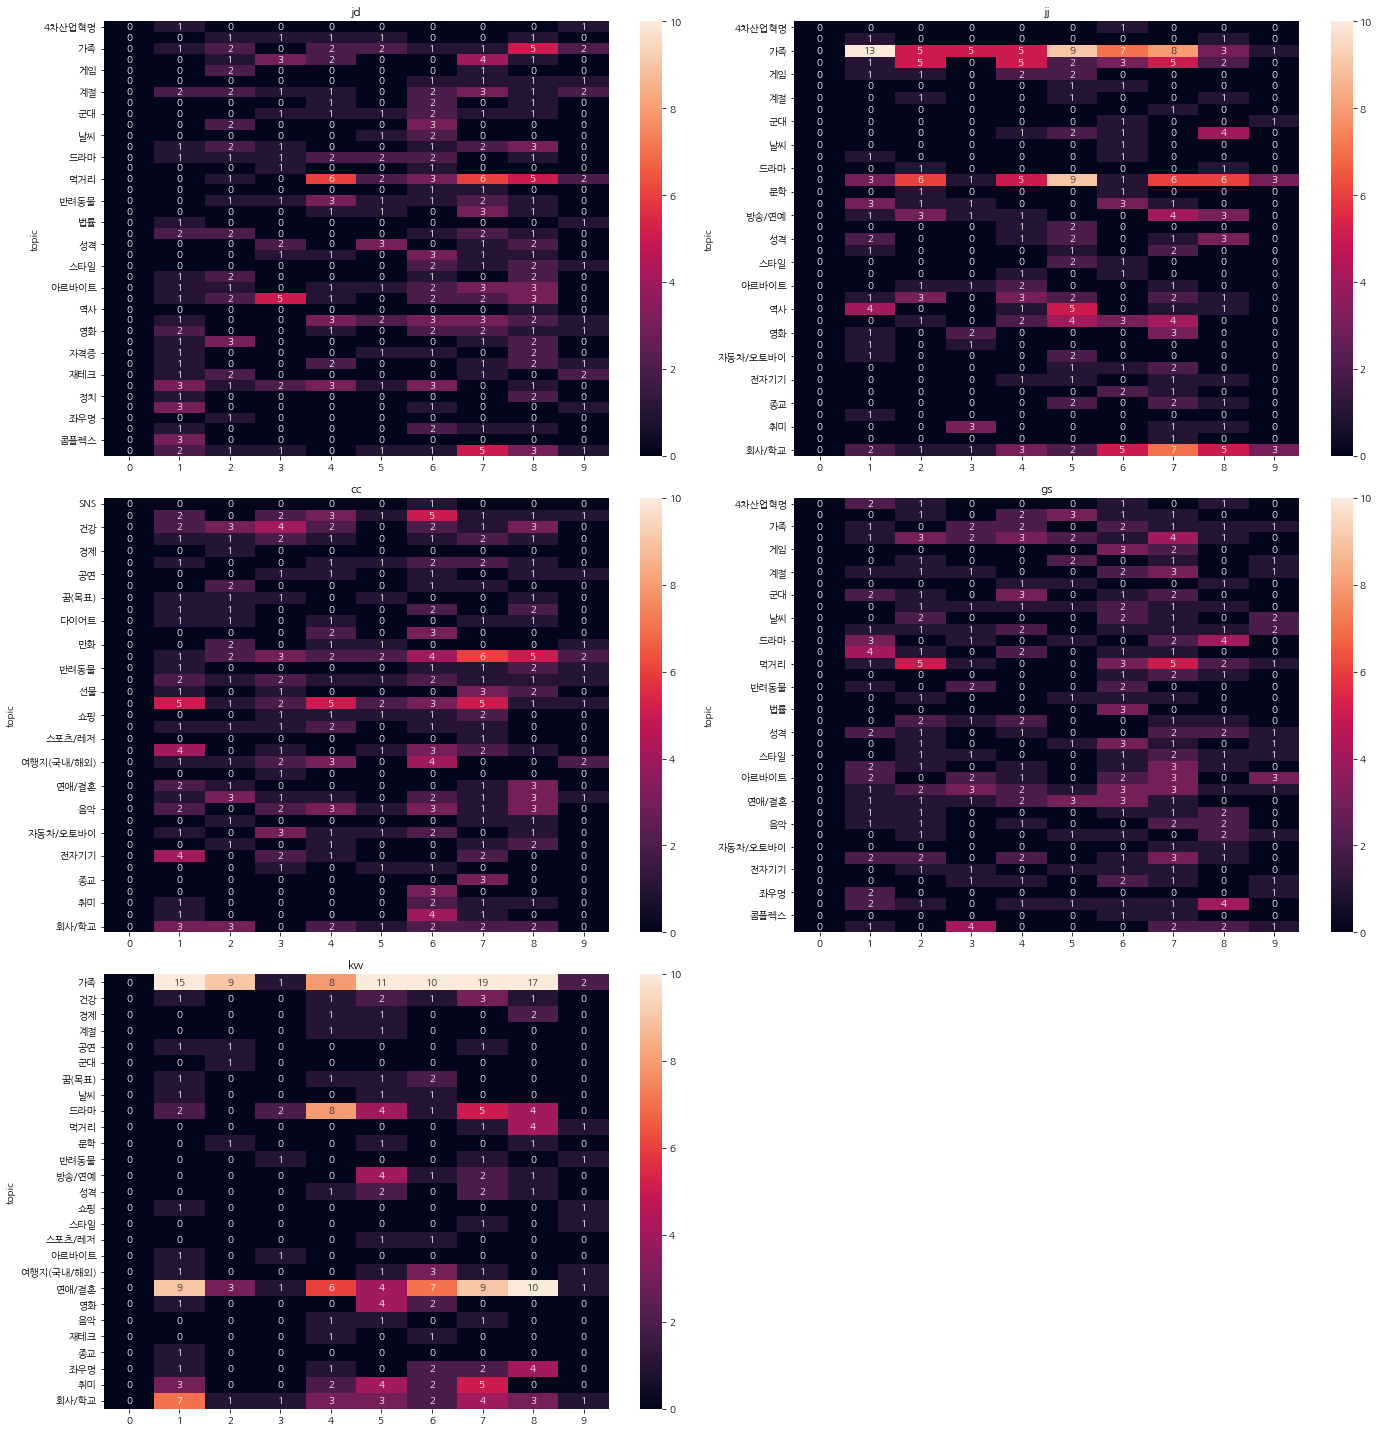

In [453]:
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'


fig = plt.figure(figsize=(20,20))
for i,reg in enumerate(regs) :
    plt.subplot(3,2,i+1)
    sns.heatmap(test_df.loc[test_df['reg']==reg].groupby(['topic'])['tok_cat'].value_counts().unstack(), annot=True,vmax=10)
    plt.title(reg)
plt.tight_layout()
plt.show()

In [454]:
assert len(train_df) + len(test_df) == len(merg_df)

In [455]:
save_col= ['reg','topic','eng','dial']
train_df[save_col].to_csv(directory + 'train_v_final_0310.csv', index=False) 
test_df[save_col].to_csv(directory + 'test_v_final_0310.csv', index=False) 